In [1]:
import itertools
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

# imputation
from miceforest import ImputationKernel

# dimensionality reduction
import pacmap

# GOSDT
from gosdt_custom import CustomGOSDT, GridSearchCVGOSDT

# PyGAM
from pygam import LogisticGAM, s, f

# L0 Regularization GLM
import l0learn

# EBM
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

# Data Preprocessing
***

### Basic Preprocessing

In [2]:
df_raw = pd.read_csv('../data/telecom_customer_churn.csv')
df_population = pd.read_csv('../data/telecom_zipcode_population.csv')

df = df_raw.copy()
df = df.query('`Customer Status` != "Joined"').reset_index(drop=True)

# join population by zip-code
df = pd.merge(left=df, right=df_population, on='Zip Code')

# remove unwanted columns
dropped_columns = ['Customer ID', 'Churn Category', 'Churn Reason', 'Latitude', 'Longitude', 'Zip Code']
df = df[[col for col in df.columns if col not in dropped_columns]]

# impute categoricals as NA
impute_na = ['Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 
             'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Multiple Lines']

df[impute_na] = df[impute_na].fillna('NA')
df['Offer'] = df['Offer'].fillna('No Offer')

# fix data types
categorical_columns = ['Gender', 'Married', 'City', 'Offer', 'Phone Service', 'Multiple Lines', 'Internet Service', 
                       'Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 
                       'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music', 
                       'Unlimited Data', 'Contract', 'Paperless Billing', 'Payment Method',
                       'Customer Status']
df[categorical_columns] = df[categorical_columns].astype('category')

arranged_columns = list(df.columns[:-2])
arranged_columns.extend(['Population', 'Customer Status'])
df = df[arranged_columns]

## Train Test Split

In [3]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], 
                                                                test_size=0.2, 
                                                                random_state=42)

## MICE Imputation for numeric missing values

Before doing the imputation, collapse the City category.

In [4]:
rare_cities = df_X_train['City'].value_counts().index[df_X_train['City'].value_counts() <= 5]

df_X_train['City'] = df_X_train['City'].astype('object')
df_X_train.loc[df_X_train['City'].isin(rare_cities), 'City'] = 'Rare City'
df_X_train['City'] = df_X_train['City'].astype('category')

In [5]:
mice_kernel = ImputationKernel(
    data = df_X_train,
    save_all_iterations = True,
    random_state = 42
)

mice_kernel.mice(2)
mice_imputation = mice_kernel.complete_data()
mice_imputation.head()

df_X_train_imp = mice_imputation.copy()

/home/vscode/.venv/lib/python3.10/site-packages/miceforest/ImputationKernel.py:370: UserWarning: [City] have very rare categories, it is a good idea to group these, or set the min_data_in_leaf parameter to prevent lightgbm from outputting 0.0 probabilities.
  warn(


In [6]:
df_X_train_imp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5271 entries, 2582 to 860
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Gender                             5271 non-null   category
 1   Age                                5271 non-null   int64   
 2   Married                            5271 non-null   category
 3   Number of Dependents               5271 non-null   int64   
 4   City                               5271 non-null   category
 5   Number of Referrals                5271 non-null   int64   
 6   Tenure in Months                   5271 non-null   int64   
 7   Offer                              5271 non-null   category
 8   Phone Service                      5271 non-null   category
 9   Avg Monthly Long Distance Charges  5271 non-null   float64 
 10  Multiple Lines                     5271 non-null   category
 11  Internet Service                   5271 non-nu

In [7]:
df_X_train_imp.head()

,Gender,Age,Married,Number of Dependents,City,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,...,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Population
2582,Male,68,No,0,Rare City,0,67,No Offer,Yes,44.56,...,Two Year,Yes,Credit Card,116.10,7839.85,0.00,40,2985.52,10865.37,4848
4397,Female,43,No,1,Rare City,0,19,No Offer,Yes,28.35,...,Month-to-Month,Yes,Bank Withdrawal,106.60,1934.45,21.72,40,538.65,2491.38,40077
6293,Female,69,Yes,0,Rare City,1,24,No Offer,Yes,13.38,...,Month-to-Month,Yes,Bank Withdrawal,93.55,2264.05,0.00,0,321.12,2585.17,152
1888,Male,24,No,0,Mountain View,0,10,Offer D,Yes,20.29,...,Month-to-Month,No,Credit Card,19.75,208.25,0.00,0,202.90,411.15,32143
1634,Male,64,No,1,Rare City,0,23,No Offer,Yes,8.40,...,Month-to-Month,No,Bank Withdrawal,54.15,1312.45,0.00,40,193.20,1545.65,57017


# EDA
***

### PaCMAP Dimensionality Reduction

In [8]:
X_train_numeric = df_X_train_imp.select_dtypes(exclude=['category'])
y_train_numeric = df_y_train.map({'Stayed': 0, 'Churned': 1}).astype('float')

# mn_ratio_list = [0.1, 0.5, 1]
# fp_ratio_list = [1, 2, 5, 7]

# pacmap_params_list = [mn_ratio_list, fp_ratio_list]

# for element in itertools.product(*pacmap_params_list):
#     # initializing the pacmap instance
#     # Setting n_neighbors to "None" leads to a default choice shown below in "parameter" section
#     embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=element[0], FP_ratio=element[1]) 

#     # fit the data (The index of transformed data corresponds to the index of the original data)
#     X_transformed = embedding.fit_transform(X_train_numeric.values, init="pca")

#     # visualize the embedding
#     fig, ax = plt.subplots(1, 1, figsize=(3, 3))
#     scatter = ax.scatter(X_transformed[:, 0], X_transformed[:, 1], cmap="Set1", c=y_train_numeric, s=0.6)

#     plt.title(f'MN Ratio: {element[0]}, FP Ratio: {element[1]}')

#     # produce a legend with the unique colors from the scatter
#     legend1 = ax.legend(scatter.legend_elements()[0],
#                         ['Stayed', 'Churned'],
#                         loc="lower right", 
#                         fontsize=6)
#     ax.add_artist(legend1)

# plt.show()

# Modeling
***

## 1. GOSDT

### Training

In [13]:
df_X_train_imp_dummies = pd.get_dummies(df_X_train_imp)

config_param_dict = {
            "regularization": [0.001, 0.01],
            "depth_budget": [4, 5],
            "time_limit": [120],
            "similar_support": [False]
         }

validator = GridSearchCVGOSDT(model=CustomGOSDT,
                              param_dict=config_param_dict,
                              metric='F1 Score',
                              folds=4)

with warnings.catch_warnings():
   warnings.simplefilter("ignore")
   results = validator.run_validation(X=df_X_train_imp_dummies,
                                       y=y_train_numeric,
                                       n_est=10,        # number of estimators for guessing thresholds
                                       max_depth=5,     # max_depth for the estimator, not the GOSDT
                                       verbose=1)



Fold: 1
gosdt reported successful execution
training completed. 0.000/0.000/0.995 (user, system, wall), mem=0 MB
bounds: [0.153977..0.153977] (0.000000) loss=0.146977, iterations=6589
Model training time: 0.0
Training accuracy: 85.3%
# of leaves: 7
{'regularization': 0.001, 'depth_budget': 4, 'time_limit': 120, 'similar_support': False, 'warm_LB': True, 'path_to_labels': '/tmp/warm_lb_labels/warm_label.tmp', 'F1 Score': 0.7006578947368421}
gosdt reported successful execution
training completed. 0.000/0.000/25.611 (user, system, wall), mem=0 MB
bounds: [0.146846..0.146846] (0.000000) loss=0.135846, iterations=183273
Model training time: 0.0
Training accuracy: 86.4%
# of leaves: 11
{'regularization': 0.001, 'depth_budget': 5, 'time_limit': 120, 'similar_support': False, 'warm_LB': True, 'path_to_labels': '/tmp/warm_lb_labels/warm_label.tmp', 'F1 Score': 0.7245508982035929}
gosdt reported successful execution
training completed. 0.000/0.000/0.641 (user, system, wall), mem=0 MB
bounds: [

### Evaluation and Visualization

Run the test data through the same steps.

In [10]:
df_X_test['City'] = df_X_test['City'].astype('object')
df_X_test.loc[df_X_test['City'].isin(rare_cities), 'City'] = 'Rare City'
df_X_test['City'] = pd.Categorical(df_X_test['City'], categories=df_X_train['City'].cat.categories)

df_X_test_imp = mice_kernel.impute_new_data(new_data=df_X_test).complete_data()
df_X_test_imp_dummies = pd.get_dummies(df_X_test_imp)

y_test_numeric = df_y_test.map({'Stayed': 0, 'Churned': 1}).astype('float')

In [14]:
results['best_params']

{'regularization': 0.01,
 'depth_budget': 5,
 'time_limit': 120,
 'similar_support': False,
 'warm_LB': True,
 'path_to_labels': '/tmp/warm_lb_labels/warm_label.tmp'}

In [15]:
gosdt = CustomGOSDT()
gosdt.config(results['best_params'])
gosdt.fit_tree(X=df_X_test_imp_dummies,
               y=y_test_numeric,
               n_est=20,    # number of estimators to use to calculate data thresholds (same as that used in CV)
               max_depth=3, # max_depth for the estimator, not the GOSDT (same as that used in CV)
               verbose=2)

preds_gosdt = gosdt.predict_labels(df_X_test_imp_dummies)
conf_matrix = gosdt.confusion_matrix(preds_gosdt, y_test_numeric)

print('='*100)
print('Confusion Matrix:')
print(conf_matrix['Confusion Matrix'])
print('F1 Score: {}'.format(conf_matrix['F1 Score']))

gosdt reported successful execution
training completed. 0.000/0.000/2.211 (user, system, wall), mem=0 MB
bounds: [0.180637..0.180637] (0.000000) loss=0.120637, iterations=43958
Model training time: 0.0
Training accuracy: 87.9%
# of leaves: 6
if Contract_Month-to-Month<=0.5 = 1 then:
    predicted class: 0.0
    misclassification penalty: 0.03
    complexity penalty: 0.01

else if Age<=64.5 = 1 and Contract_Month-to-Month<=0.5 != 1 and Monthly Charge<=78.4000015258789 = 1 and Tenure in Months<=3.5 = 1 then:
    predicted class: 1.0
    misclassification penalty: 0.0
    complexity penalty: 0.01

else if Age<=64.5 = 1 and Contract_Month-to-Month<=0.5 != 1 and Monthly Charge<=78.4000015258789 = 1 and Tenure in Months<=3.5 != 1 then:
    predicted class: 0.0
    misclassification penalty: 0.039
    complexity penalty: 0.01

else if Age<=64.5 = 1 and Contract_Month-to-Month<=0.5 != 1 and Monthly Charge<=78.4000015258789 != 1 and Tenure in Months<=17.5 = 1 then:
    predicted class: 1.0
    

In [17]:
df_X_test_imp_dummies[['Contract_Month-to-Month']].value_counts()

Contract_Month-to-Month
False                      661
True                       657
Name: count, dtype: int64

In [18]:
df_X_test_imp_dummies['Tenure in Months'].describe()

count    1318.000000
mean       34.089530
std        24.029428
min         1.000000
25%        12.000000
50%        31.500000
75%        57.000000
max        72.000000
Name: Tenure in Months, dtype: float64

## 2. GAM

### Training

In [24]:
gam_subset = ['Contract', 'Number of Referrals', 'Tenure in Months', 
               'Number of Dependents', 'Payment Method', 'Total Revenue', 
               'Total Charges', 'Monthly Charge', 'Online Security', 
               'Total Long Distance Charges']

df_X_train_imp_subset = df_X_train_imp[gam_subset]

df_X_train_imp_subset_dummies = pd.get_dummies(df_X_train_imp_subset, dtype='float')

In [20]:
gam = \
    LogisticGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + f(7) + f(8) + f(9) + f(10) + f(11) + f(12) + f(13) + f(14) + f(15))

_ = gam.gridsearch(df_X_train_imp_subset_dummies.values, y_train_numeric)


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:09
 18% (2 of 11) |####                     | Elapsed Time: 0:00:01 ETA:   0:00:06
 27% (3 of 11) |######                   | Elapsed Time: 0:00:01 ETA:   0:00:05
 36% (4 of 11) |#########                | Elapsed Time: 0:00:02 ETA:   0:00:04
 45% (5 of 11) |###########              | Elapsed Time: 0:00:02 ETA:   0:00:03
 54% (6 of 11) |#############            | Elapsed Time: 0:00:03 ETA:   0:00:02
 63% (7 of 11) |###############          | Elapsed Time: 0:00:03 ETA:   0:00:01
 72% (8 of 11) |##################       | Elapsed Time: 0:00:04 ETA:   0:00:01
 81% (9 of 11) |####################     | Elapsed Time: 0:00:04 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:04 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:05 Time:  0:00:05


LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + f(7) + f(8) + f(9) + f(10) + f(11) + f(12) + f(13) + f(14) + f(15) + intercept,
   tol=0.0001, verbose=False)

### Evaluation and Visualization

In [31]:
df_X_test_imp_subset = df_X_test_imp[gam_subset]

df_X_test_imp_subset_gam = pd.get_dummies(df_X_test_imp_subset, dtype='float')

In [37]:
preds_gam = gam.predict(df_X_test_imp_subset_gam)
preds_gam = pd.Series(preds_gam).map({True: 'Churned', False: 'Stayed'})

print(confusion_matrix(df_y_test, preds_gam))
f1_score(df_y_test.values, preds_gam, pos_label='Churned')

[[269 102]
 [ 67 880]]


0.760961810466761

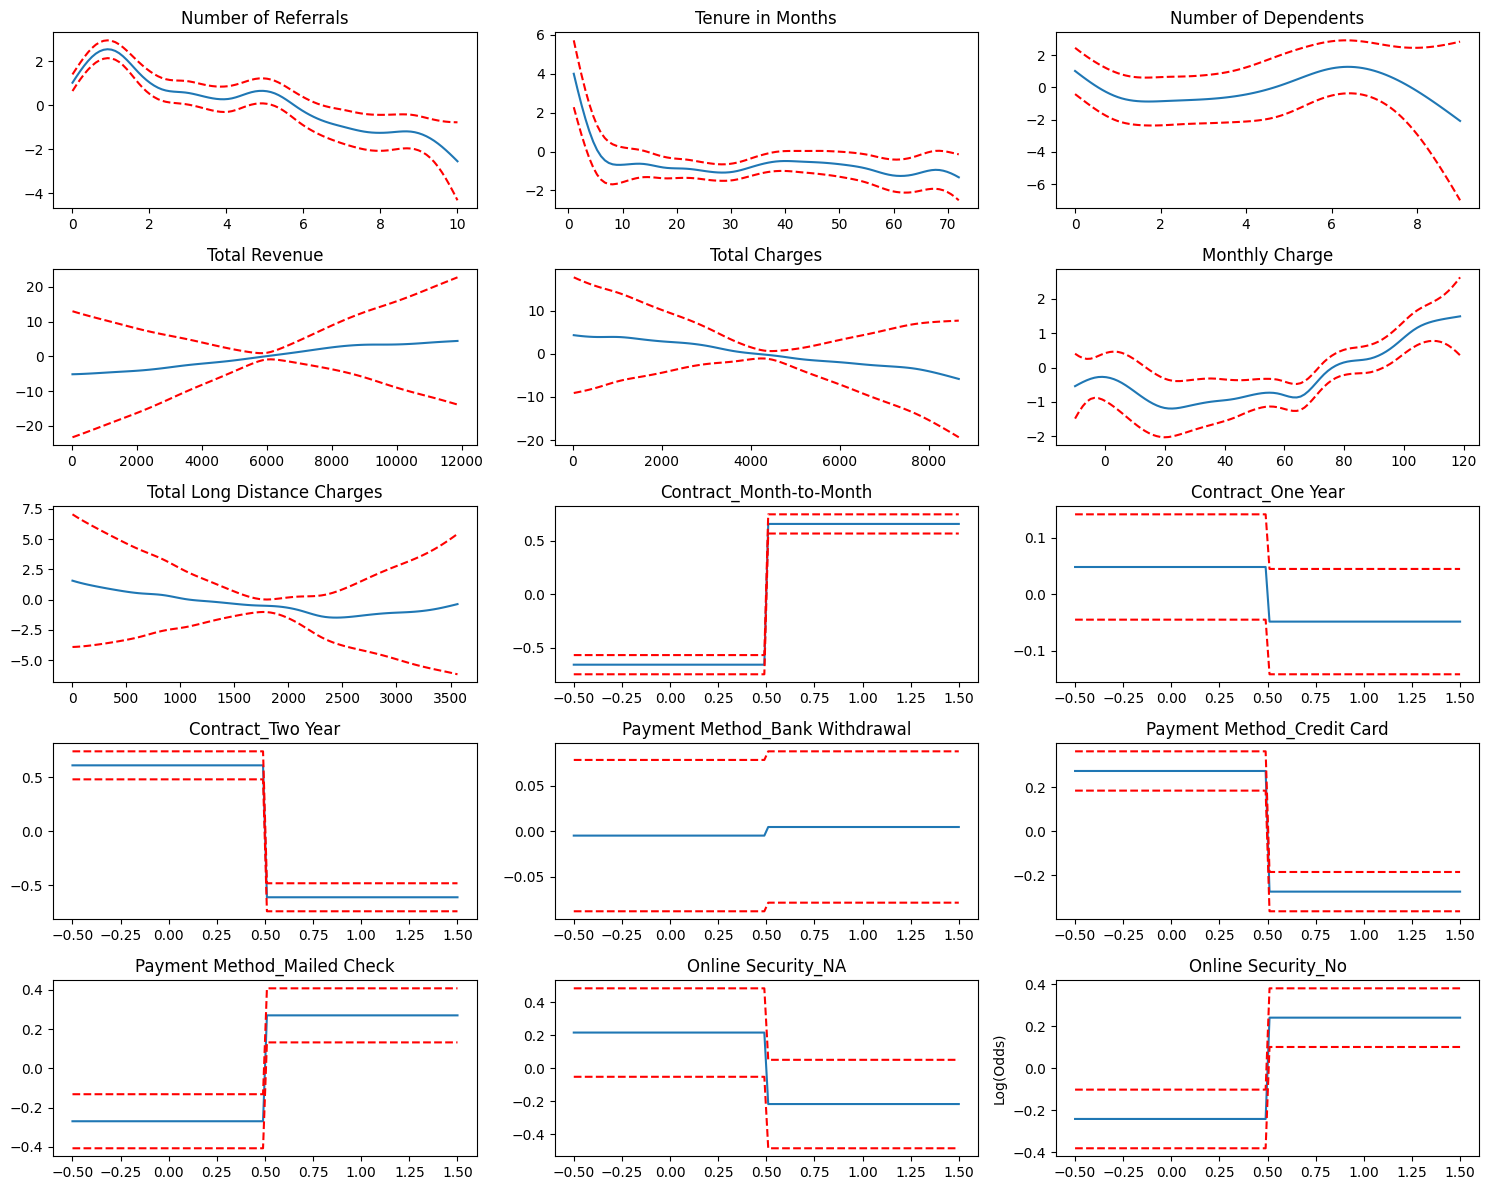

In [38]:
fig, axs = plt.subplots(5, 3, figsize=(15, 12))
titles = df_X_train_imp_subset_dummies.columns

for i, ax in enumerate(axs.ravel()):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);

plt.ylabel("Log(Odds)")
plt.tight_layout()

## 3. L0Learn

### Training

In [42]:
df_X_train_imp_dummies_floats = pd.get_dummies(df_X_train_imp, dtype='float')

user_lambda_grid = [[10, 4, 2, 1]]

cv_fit_result = l0learn.cvfit(df_X_train_imp_dummies_floats.values, 
                              y_train_numeric.values, 
                              num_folds=5, 
                              seed=42, 
                              penalty="L0", 
                              loss='Logistic',
                              num_gamma=None, 
                              num_lambda=None,
                              max_support_size=30, 
                              lambda_grid=user_lambda_grid)

cv_fit_result.characteristics().join(pd.Series(cv_fit_result.cv_means[0].flatten(), name='Loss'))

,l0,support_size,intercept,converged,l2,Loss
0,10.0,13,-0.880785,True,1.000000e-07,0.346542
1,4.0,15,-1.579728,True,1.000000e-07,0.343729
2,2.0,19,-1.783571,True,1.000000e-07,0.340826
3,1.0,31,-1.821026,True,1.000000e-07,0.341699


In [44]:
# use the value of l0 that gives lowest loss
best_fit = l0learn.fit(df_X_train_imp_dummies_floats.values, 
                       y_train_numeric.values, 
                       penalty="L0", 
                       loss='Logistic', 
                       max_support_size=30, 
                       num_lambda=2)

### Evaluation and Visualization

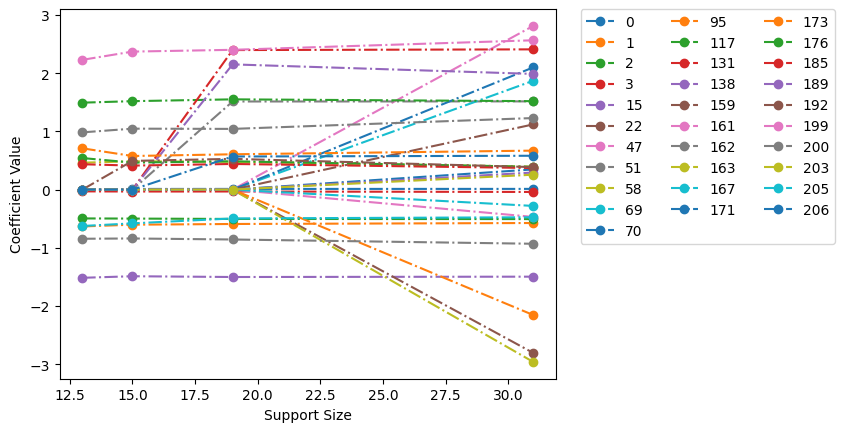

In [45]:
cv_fit_result.plot(show_lines=True);

In [73]:
df_X_test_imp_dummies_float = pd.get_dummies(df_X_test_imp, dtype='float')
l0learn_preds = cv_fit_result.predict(df_X_test_imp_dummies_float.values)[:, 2]
l0learn_preds = ['Churned' if x >= 0.5 else 'Stayed' for x in l0learn_preds]

In [75]:
print(confusion_matrix(df_y_test, l0learn_preds))
f1_score(df_y_test.values, l0learn_preds, pos_label='Churned')

[[271 100]
 [ 94 853]]


0.7364130434782608

In [94]:
coefficients_l0learn = pd.DataFrame(zip(df_X_train_imp_dummies_floats.columns, 
                                        cv_fit_result.coeffs[0].toarray()[:, 2]),
                                        columns=['Column Name', 'Coefficient'])\
                                            .query('Coefficient != 0')

coefficients_l0learn['Coeff_abs'] = coefficients_l0learn['Coefficient'].abs()
coefficients_l0learn.sort_values(by='Coeff_abs', inplace=True, ascending=False)
coefficients_l0learn = coefficients_l0learn.drop(columns=['Coeff_abs'])

In [95]:
coefficients_l0learn

,Column Name,Coefficient
199,Contract_Month-to-Month,2.401706
131,City_Santa Rosa,2.397308
138,City_Temecula,2.151380
117,City_San Diego,1.550782
51,City_Fallbrook,1.513787
15,Married_No,-1.501532
200,Contract_One Year,1.043020
162,Offer_Offer D,-0.857082
173,Internet Type_Fiber Optic,0.606806
1,Number of Dependents,-0.590627
